In [1]:
import numpy as np
import os
import pathlib
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import open3d as o3d
from sklearn.cluster import KMeans, k_means, DBSCAN
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Functions for dephs stimation from jorgen

In [2]:
def nothing(x):
    pass

def semiGlobalMatchMap(left_img, right_img):
    """Function using the SGMBM algorithm to compute the disparity map

    Args:
        left_img (ndarray): color image of the left camera
        right_img (ndarray): color image of the right camera

    Returns:
        stereo: the SGMBM object
        disparity: the disparity map
    """    
    
    cv2.namedWindow('disp',cv2.WINDOW_NORMAL)
    cv2.resizeWindow('disp',800,800)
    
    ###### Default values ######
    blockSize = 7          # odd number, usually in range 3-11
    minDisparity = -1
    maxDisparity = 6       
    numDisparities = maxDisparity-minDisparity  # max disparity minus minDisparity, must be divisible by 16
    preFilterCap = 0
    uniquenessRatio = 1

    # affect the noise
    speckleRange = 1       # multiplied by 16 implicitly, 1 or 2 usually good
    speckleWindowSize = 54 # 50-200 range
    ###################
    
    cv2.createTrackbar('minDisparity','disp',minDisparity,17,nothing)
    cv2.createTrackbar('numDisparities','disp',numDisparities,17,nothing)
    cv2.createTrackbar('blockSize','disp',blockSize,20,nothing)
    cv2.createTrackbar('preFilterCap','disp',preFilterCap,62,nothing)
    cv2.createTrackbar('uniquenessRatio','disp',uniquenessRatio,10,nothing)
    cv2.createTrackbar('speckleRange','disp',speckleRange,5,nothing)
    cv2.createTrackbar('speckleWindowSize','disp',speckleWindowSize,250,nothing)
    
    # Creating an object of StereoBM algorithm
    leftMatcher = cv2.StereoSGBM_create()
    
    while True:
        
        # Updating the parameters based on the trackbar positions
        numDisparities = cv2.getTrackbarPos('numDisparities','disp')*16
        numDisparities = 16 if numDisparities == 0 else numDisparities
        blockSize = cv2.getTrackbarPos('blockSize','disp')
        preFilterCap = cv2.getTrackbarPos('preFilterCap','disp')
        preFilterCap = 1 if preFilterCap == 0 else preFilterCap
        if blockSize % 2 == 0:
            blockSize += 1

        if blockSize < 5:
            blockSize = 5

        uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio','disp')
        speckleRange = cv2.getTrackbarPos('speckleRange','disp')
        speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize','disp')
        minDisparity = cv2.getTrackbarPos('minDisparity','disp')
            
        # Setting the updated parameters before computing disparity map
        leftMatcher.setNumDisparities(numDisparities)
        leftMatcher.setBlockSize(blockSize)
        leftMatcher.setUniquenessRatio(uniquenessRatio)
        leftMatcher.setSpeckleRange(speckleRange)
        leftMatcher.setSpeckleWindowSize(speckleWindowSize)
        leftMatcher.setMinDisparity(minDisparity)
        # P1 and P2 values from OpenCV documentation
        leftMatcher.setP1(8*3*blockSize**2)
        leftMatcher.setP2(32*3*blockSize**2)
        
        # Calculating disparity using the stereoBM algorithm
        leftDisparity =  leftMatcher.compute(left_img, right_img).astype(np.float32)
        distL = cv2.ximgproc.getDisparityVis(leftDisparity)

        # Displaying the disparity map
        cv2.imshow("disp",distL)
    
        # Close window using esc key
        if cv2.waitKey(1) == 27:
            break 
    cv2.destroyAllWindows()
    return leftMatcher, distL

In [3]:
def readAllColorMatrices():
    """Function to read all the interesting matrices in the calib_cam_to_cam.txt file

    Returns:
        matrices: all the relevant matrices for the colored images
    """    
    path = "../data/final_project_2023_rect/calib_cam_to_cam.txt"
    
    with open(path, 'r') as f:
        fin = f.readlines()
        for line in fin:
            if line[:4] == "R_02":
                rotation2 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "R_03":
                rotation3 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "K_02":
                intrinsic2 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "K_03":
                intrinsic3 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "T_02":
                translation2 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "T_03":
                translation3 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "S_rect_02":
                imageSize2 = np.array(line[11:].strip().split(" ")).astype('float32')
            elif line[:9] == "S_rect_03":
                imageSize3 = np.array(line[11:].strip().split(" ")).astype('float32')
            elif line[:9] == "R_rect_02":
                rectRot2 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "R_rect_03":
                rectRot3 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "P_rect_02":
                camMatrix2 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "P_rect_03":
                camMatrix3 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
    
    return rotation2, rotation3, translation2, translation3, imageSize2, imageSize3, \
            rectRot2, rectRot3, camMatrix2, camMatrix3, intrinsic2, intrinsic3

In [4]:
def export_pointcloud(disparity_map, colors, filename):

    def write_ply(fn, verts, colors):
        ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
        colors = colors.copy()
        verts = verts.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open("pointclouds/"+fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
    
    rot2, rot3, trans2, trans3, imgSize2, imgSize3, rectRot2, rectRot3,\
    cam2, cam3, k2, k3 = readAllColorMatrices()
    # Q = calculateQManually(cam2, cam3)        # We let opencv calculate the Q matrix
    
    cam2 = cam2[:,:3]
    cam3 = cam3[:,:3]
    Tmat = np.array([0.54, 0.0, 0.0])   # From the KITTI Sensor setup, in metres 
    cvQ = np.zeros((4,4))
    cv2.stereoRectify(cameraMatrix1=cam2, cameraMatrix2=cam3, distCoeffs1=0, distCoeffs2=0,
                        imageSize=colors.shape[:2], R=np.identity(3), T=Tmat, 
                        R1=None, R2=None,P1=None, P2=None, Q=cvQ)
    
    points = cv2.reprojectImageTo3D(disparity_map, cvQ, handleMissingValues=False)

    #reflect on x axis
    reflect_matrix = np.identity(3)
    reflect_matrix[0] *= -1
    points = np.matmul(points,reflect_matrix)
    
    colors = cv2.cvtColor(colors, cv2.COLOR_BGR2RGB) # Extract colors from image
    mask = disparity_map > disparity_map.min()
    out_points = points[mask]
    out_colors = colors[mask]
    
    #filter by dimension
    idx = np.fabs(out_points[:,0]) < 4.5
    out_points = out_points[idx]
    out_colors = out_colors.reshape(-1, 3)
    out_colors = out_colors[idx]

    write_ply(filename, out_points, out_colors)
    print(f'{filename} saved')
    return out_points, reflect_matrix, idx, cam2, mask

In [5]:
def pointcloudToImage(points, reflectMat, idx, cam3, mask, left_img, right_img):
    # Verify the pointcloud by going back to the original image based on the points
    reflected_pts = np.matmul(points, reflectMat)
    projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                            cam3[:3,:3], np.array([0., 0., 0., 0.]))
    projected_img = projected_img.reshape(-1, 2)

    blank_img = np.zeros(left_img.shape, 'uint8')
    img_colors = right_img[mask][idx].reshape(-1,3)

    for i, pt in enumerate(projected_img):
        pt_x = int(pt[0])
        pt_y = int(pt[1])
        if pt_x > 0 and pt_y > 0:
            # use the BGR format to match the original image type
            col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
            cv2.circle(blank_img, (pt_x, pt_y), 1, col)
    return blank_img

### Load the directories

In [6]:
##################
_fr_num = 0
################


ROOT_DIR = pathlib.Path(os.getcwd()).parent
DATA_DIR = ROOT_DIR / "data/final_project_2023_rect"
SEQ_01 = DATA_DIR / "seq_01"
SEQ_02 = DATA_DIR / "seq_01"
SEQ_03 = DATA_DIR / "seq_01"

## Get the images
left_path = SEQ_01 / "image_02/data/*.png"
right_path = SEQ_01 / "image_03/data/*.png"
print(left_path)
left_images = glob.glob(str(left_path))
right_images = glob.glob(str(right_path))
left_images.sort()
right_images.sort()
print(len(left_images), len(right_images))



maxTimeStep = len(right_images)
print(maxTimeStep)

old_disparity = new_disparity = None

c:\Users\alexc\OneDrive - Danmarks Tekniske Universitet\DTU\Second Semester\34759 - Perception Autonomous\Exercises\Pfas-finalProject\data\final_project_2023_rect\seq_01\image_02\data\*.png
145 145
145


In [7]:
def get_labels_df(seq_dir_):
    """
    returns the labels (ground truth data) of the given sequence as a pandas dataframe
    :param seq_dir_: sequence directory (pathlib.Path)
    :return: labels dataframe (pd.DataFrame)
    """

    _labels_file = str(seq_dir_ / "labels.txt")
    headers = ['frame', 'track_id', 'type', 'truncated', 'occluded', 'alpha', 'bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom', 'height', 'width', 'length', 'x', 'y', 'z', 'yaw']
    return pd.read_csv(_labels_file, sep=' ', header=None, names=headers)

# draw boxes on frame
def draw_bboxes(frame_, bbox_coords_):
    """draw boxes"""
    _frame = frame_.copy()
    for bbox in bbox_coords_:
        cv2.rectangle(_frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)
    return _frame

def get_frames(frame_num_, seq_dir_):
    """
    returns the right and left frames of the given sequence for a given frame number
    :param frame_num_: frame number (int)
    :param seq_dir_: sequence directory (pathlib.Path)
    :return: right and left frame (np.ndarray, np.ndarray)
    """
    _frame_name_r = str(seq_dir_ / "image_02/data" / f"{frame_num_:06d}.png")
    _frame_name_l = str(seq_dir_ / "image_03/data" / f"{frame_num_:06d}.png")

    if not os.path.isfile(_frame_name_r):
        raise FileNotFoundError(f"File {_frame_name_r} not found")
    if not os.path.isfile(_frame_name_l):
        raise FileNotFoundError(f"File {_frame_name_l} not found")
    
    return cv2.cvtColor(cv2.imread(_frame_name_r), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(_frame_name_l), cv2.COLOR_BGR2RGB)

# Iony implementation of boxes of GT

In [8]:

# lets obtain the info about the bounding boxes
# we will use the bounding boxes to generate the point cloud

# get labels df
labels_df = get_labels_df(SEQ_01)

# make dfs for each type
car_df = labels_df[labels_df['type'] == 'Car']
pedestrian_df = labels_df[labels_df['type'] == 'Pedestrian']
cyclist_df = labels_df[labels_df['type'] == 'Cyclist']

# get a specific tracked object's info
track_id = 0
test_df = pedestrian_df[pedestrian_df['track_id'] == track_id]

frames = test_df['frame'].values
world_coords = test_df[['x', 'y', 'z']].values
bbox_coords = test_df[['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']].values


seq = SEQ_01
_bb = bbox_coords[_fr_num]

# filter pedestrian for frame two
_bb = pedestrian_df[pedestrian_df['frame'] == 0]
_bb = _bb[['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']]
print(_bb)
    

    bbox_left    bbox_top  bbox_right  bbox_bottom
0  466.194319  139.161762  557.194320   332.842544
1  389.158096  150.885617  497.158096   359.917155
2  485.398585  145.273299  502.065252   200.312156
3  525.723004  137.996529  541.389670   191.857804
4  545.146393  143.123321  559.813059   190.469783
5  568.546716  145.927759  581.213382   191.540706


## Mask creation in 2d before pointcloud

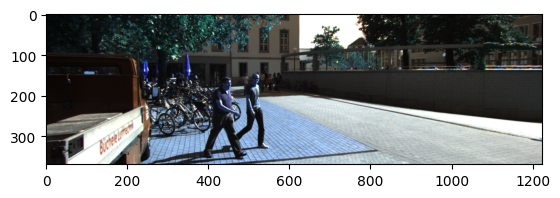

In [9]:
# Apply minor blur to improve the resutlts of the disparity map
# TODO: Alex: I dont know why is improving, double check
left_img = cv2.imread(left_images[_fr_num])
right_img = cv2.imread(right_images[_fr_num])

left_img_blur = cv2.blur(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY), (5,5))
right_img_blur = cv2.blur(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY), (5,5))


plt.imshow(left_img)

## Calculate disparity map using depth

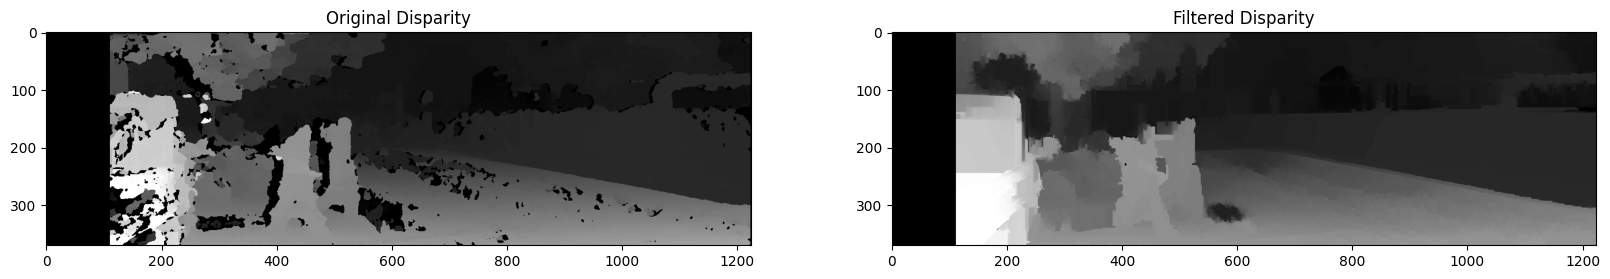

C:\Users\alexc\AppData\Local\Temp\ipykernel_8640\665268004.py:39: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points,reflect_matrix)


pointcloud_fr0.ply saved


In [10]:
sgbmObject, disparityMap = semiGlobalMatchMap(left_img_blur, right_img_blur)


# Calculate the disparity map and apply WLS filter
leftMatcher = sgbmObject
rightMatcher = cv2.ximgproc.createRightMatcher(leftMatcher)

# Calculating disparity using the stereoBM algorithm
leftDisparity =  leftMatcher.compute(left_img_blur, right_img_blur)
rightDisparity = rightMatcher.compute(right_img_blur, left_img_blur)

# Create a WLS (weighted least squares) filter (source: https://docs.opencv.org/3.4/d3/d14/tutorial_ximgproc_disparity_filtering.html) 
wlsFilter = cv2.ximgproc.createDisparityWLSFilter(leftMatcher)
wlsFilter.setLambda(8000)     # The tuning parameter, depends on the range of disparity values
wlsFilter.setSigmaColor(0.7)    # Adjusts the filter's sensitivity to edges in the image (between 0.8 and 2.0 usually good)

filteredDisparity = wlsFilter.filter(leftDisparity, left_img_blur, None, rightDisparity)

# Get the original and filtered disparity images
orgDistL = cv2.ximgproc.getDisparityVis(leftDisparity)
filteredL = cv2.ximgproc.getDisparityVis(filteredDisparity)

# Visualize the images one above the other
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(orgDistL, 'gray')
plt.title('Original Disparity')
plt.subplot(222)
plt.imshow(filteredL, 'gray')
plt.title('Filtered Disparity')
plt.show()

points, reflectMat, idx, cam3, mask = export_pointcloud(filteredL, left_img, "pointcloud_fr0.ply")

C:\Users\alexc\AppData\Local\Temp\ipykernel_8640\665268004.py:39: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points,reflect_matrix)


pointcloud_original.ply saved


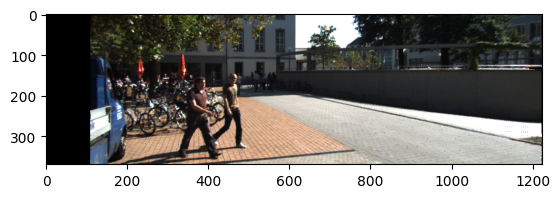

In [11]:
points, reflectMat, idx, cam2, mask = export_pointcloud(filteredDisparity, left_img, "pointcloud_original.ply")

blank_img = pointcloudToImage(points, reflectMat, idx, cam2, mask, left_img, right_img)
plt.imshow(blank_img, 'gray')

## Apply mask to disparity map

(370, 1224)
(370, 1224)
(370, 1224)


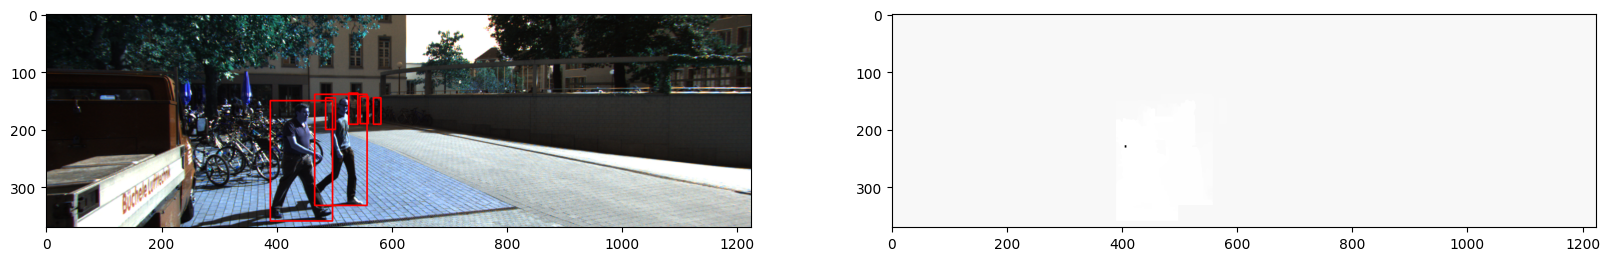

In [12]:
_bb = bbox_coords[_fr_num]

# filter pedestrian for frame two
_bb = pedestrian_df[pedestrian_df['frame'] == _fr_num]
_bb = _bb[['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']]

# Create mask for disparity map
mask = np.zeros(filteredDisparity.shape, dtype=np.uint8)
print(mask.shape)
# read bbox coords
for bb in _bb.values:
    mask[int(bb[1]):int(bb[3]), int(bb[0]): int(bb[2])] = 255
    
print(mask.shape)
maskedDisparity = filteredDisparity.copy()
maskedDisparity[mask == 0] = 0
print(maskedDisparity.shape)

# plot the boxes in the original image and the masked disparity map
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(draw_bboxes(left_img, _bb.values), cmap='gray')
plt.subplot(122)
plt.imshow(maskedDisparity, 'gray')



## Export masked pointcloud

In [13]:
points, reflectMat, idx, cam3, mask = export_pointcloud(maskedDisparity, left_img, "filteredDispparity.ply")


C:\Users\alexc\AppData\Local\Temp\ipykernel_8640\665268004.py:39: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points,reflect_matrix)


filteredDispparity.ply saved


## Apply clustering the number of detections

In [14]:
## Helpers functions
def draw_labels_on_model(pcl, labels):
    cmap = plt.get_cmap("tab20")
    pcl_temp = copy.deepcopy(pcl)
    max_label = labels.max()
    print("%s has %d clusters" % (pcl, max_label + 1))
    colors = cmap(labels / (max_label if max_label > 0 else 1))
    colors[labels < 0] = 0
    pcl_temp.colors = o3d.utility.Vector3dVector(colors[:, :3])
    o3d.visualization.draw_geometries([pcl_temp])

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

In [15]:
maskPointCloud = o3d.io.read_point_cloud("pointclouds\pointcloud_MASKtest.ply")
detected_objects = len(_bb.values)
print("Detected boxes: ", detected_objects)

Detected boxes:  6


In [16]:
# Kmeans clustering
km = KMeans(n_clusters=detected_objects, init='random',
            n_init=10, max_iter=300, tol=1e-04, random_state=0)

# Get the points from the pointcloud as nparray
xyz = np.asarray(maskPointCloud.points)
labels = km.fit_predict(xyz)
draw_labels_on_model(maskPointCloud, labels)

PointCloud with 35205 points. has 6 clusters


In [20]:
# DBSCAN clustering
xyz = np.asarray(maskPointCloud.points)
db = DBSCAN(eps=0.02, min_samples=100).fit(xyz)
labels = db.labels_
draw_labels_on_model(maskPointCloud, labels)

[[-0.280947  0.154563 -2.511886]
 [-0.277395  0.154563 -2.511886]
 [-0.273842  0.154563 -2.511886]
 ...
 [-0.059563 -0.096039 -0.382572]
 [-0.059081 -0.096135 -0.382955]
 [-0.05854  -0.096135 -0.382955]]


MemoryError: bad allocation

In [ ]:

maskPointCloud1 = o3d.io.read_point_cloud("pointclouds\pointcloud_MASKtest.ply")
maskPointCloud2 = o3d.io.read_point_cloud("pointclouds\pointcloud_MASKtest-r.ply")

# stadistical outlier removal
cl, ind = maskPointCloud1.remove_statistical_outlier(nb_neighbors=2, std_ratio=2.0)
inlier_cloud1 = maskPointCloud1.select_by_index(ind)

cl, ind = maskPointCloud2.remove_statistical_outlier(nb_neighbors=2, std_ratio=2.0)
inlier_cloud2 = maskPointCloud2.select_by_index(ind)

#display_inlier_outlier(maskPointCloud1, ind)
#display_inlier_outlier(maskPointCloud2, ind)

In [ ]:
# Apply DBSCAN clustering in the seccond image
xyz = np.asarray(inlier_cloud1.points)
db = DBSCAN(eps=0.2, min_samples=50).fit(xyz)
labels1 = db.labels_
print(len(labels))
#draw_labels_on_model(inlier_cloud1, labels1)


27071


In [ ]:
# Apply DBSCAN clustering in the seccond image
xyz = np.asarray(inlier_cloud2.points)
db = DBSCAN(eps=0.2, min_samples=50).fit(xyz)
labels2 = db.labels_
print(len(labels))
#draw_labels_on_model(inlier_cloud2, labels2)

27071


In [19]:

# Get the 2 most appering value in the labels
from collections import Counter

def obtain_n_biggest_cluster_from_pointcloud(initialPointCloud, labels, n_detected):
    """Recieves a single pointCloud with its labels and return a list
       of pointclouds with the n biggest clusters.
    """
    # Get the biggest cluster
    id_clusters = Counter(labels).most_common(n_detected)
    id_clusters = [id[0] for id in id_clusters]

    point_clouds_by_object = []

    # For each cluster we obtain the list of index create pointcloud and store in a list
    for id in id_clusters:
        new_cluster = []
        for i, l in enumerate(labels):
            if l == id:
                new_cluster.append(i)
        # create pointcloud and add it
        cluster = initialPointCloud.select_by_index(new_cluster)
        point_clouds_by_object.append(cluster)

    return point_clouds_by_object

# TODO: get the minimun number of objects detected beetween frames
# cannot track new items
n_detection = 2

clusters1 = obtain_n_biggest_cluster_from_pointcloud(inlier_cloud1, labels1, n_detection)
clusters2 = obtain_n_biggest_cluster_from_pointcloud(inlier_cloud2, labels2, n_detection)

# plot
#o3d.visualization.draw_geometries([clusters1[0]])
#o3d.visualization.draw_geometries([clusters2[0]])

NameError: name 'inlier_cloud1' is not defined

## Naive approach: avg point Cloud

In [84]:
# Calculate the avg point in each cluster
def calculate_avg_point_in_cluster(cluster):
    """Recieves a pointcloud and return the average point"""
    xyz = np.asarray(cluster.points)
    return np.mean(xyz, axis=0)


# calculate the vector beetwen frames
origins = []
vectors = []
destinations = []
for i in range(n_detection):
    avg1 = calculate_avg_point_in_cluster(clusters1[i])
    avg2 = calculate_avg_point_in_cluster(clusters2[i])
    
    # calculate vector between points
    origins.append(avg1)
    destinations.append(avg2)
    
    vector = avg2 - avg1
    vectors.append(vector)
    print(f"Cluster {i} moved beetween frames: {0} - {1} -->Vector: {vector}")


Cluster 0 moved beetween frames: 0 - 1 -->Vector: [0. 0. 0.]
Cluster 1 moved beetween frames: 0 - 1 -->Vector: [0. 0. 0.]


In [85]:
# calculate the bounding boxes for each cluster
def calculate_bounding_box(cluster):
    """Recieves a pointcloud and return the bounding box surrounding it"""
    bbox = cluster.get_axis_aligned_bounding_box()
    return bbox

bb = calculate_bounding_box(clusters1[0])
# change color of bounding to red color
bb.color = [255, 0, 0]

# create a vector in open3d and add it to the plot
# we used origins and destinations
vector = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin= (0, 0 , 0))
vector2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin= origins[0])

# plot

center = bb.get_center()
avg = calculate_avg_point_in_cluster(clusters1[0])
print(center)
print(avg)
print("bbox values:")
print("x = " + str(center[0]))
print("y = " + str(center[1]))
print("z = " + str(center[2]))

o3d.visualization.draw_geometries([clusters1[0], vector , vector2])

[-1.4226765 -0.697601  -6.563692 ]
[-1.46049787 -0.86298011 -6.14245527]
bbox values:
x = -1.4226765000000001
y = -0.6976009999999999
z = -6.563692


## Plot the boinding boxes in the original pointClous

In [18]:

originalPointCloud = o3d.io.read_point_cloud("pointclouds\filteredDispparity.ply")
o3d.visualization.draw_geometries([originalPointCloud])
# Plot the orinial pointcloud with the bounding boxes of the different clusters using 
# a different color for each cluster
vector = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin= origins[0])
vector2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin= origins[1])
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin= (0, 0 , 0))

gt1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin= (0.834498, -0.875495, 1.374252))


bb1 = calculate_bounding_box(clusters1[0])
bb1.color = [255, 0, 0]
bb2 = calculate_bounding_box(clusters1[1])
bb2.color = [0, 255, 0]

bb1_2 = calculate_bounding_box(clusters2[0])
bb1_2.color = [255, 0, 0]
bb2_2 = calculate_bounding_box(clusters2[1])
bb2_2.color = [0, 255, 0]

print("Location: " + str(origins[0]))
# o3d.visualization.draw_geometries([clusters2[0], clusters2[1] ,vector, vector2, bb1, bb2, origin])

o3d.visualization.draw_geometries([originalPointCloud, bb1_2, bb2_2, origin, gt1])

[Open3D WARNING] Read PLY failed: unable to open file: pointcloudsilteredDispparity.ply


NameError: name 'origins' is not defined

In [95]:
def pointcloudToImage(points, reflectMat, idx, cam3, mask, left_img, right_img):
    # Verify the pointcloud by going back to the original image based on the points
    reflected_pts = np.matmul(points, reflectMat)
    projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                            cam3[:3,:3], np.array([0., 0., 0., 0.]))
    projected_img = projected_img.reshape(-1, 2)

    blank_img = np.zeros(left_img.shape, 'uint8')
    img_colors = right_img[mask][idx].reshape(-1,3)

    for i, pt in enumerate(projected_img):
        pt_x = int(pt[0])
        pt_y = int(pt[1])
        if pt_x > 0 and pt_y > 0:
            # use the BGR format to match the original image type
            col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
            cv2.circle(blank_img, (pt_x, pt_y), 1, col)
    return blank_img

C:\Users\alexc\AppData\Local\Temp\ipykernel_14556\665268004.py:39: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points,reflect_matrix)


filteredDispparity.ply saved


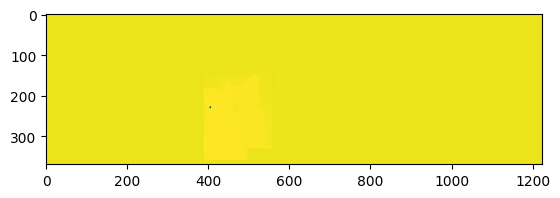

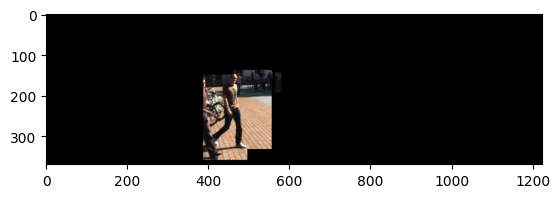

In [14]:
points, reflectMat, idx, cam2, mask = export_pointcloud(dis, left_img, "filteredDispparity.ply")
# plot img
plt.imshow(maskedDisparity)
plt.show()

blank_img = pointcloudToImage(points, reflectMat, idx, cam2, mask, left_img, right_img)

# plot img  
plt.imshow(blank_img)
plt.show()
